 GROUP COMPONENTS:
- Tito Tamburini
- Angelo Mandara
- Enrico Grimaldi
- Claudiu Gabriel Gheorghiu
- Giuseppe Di Poce


# Motivation and importance in this field

 We therefore report an extremely current issue given that
digital transactions are exponentially increasing, so security in this context is critical. In this way is possible
to increase the user base for this type of service, boosting the traceability of payments, control of shady money
movements and reducing the tax evasion rate.

# Fraudulent Transactions Detection

### Context
We are going to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

### Content

Data Dictionary:

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Useful packages import

In [3]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor #multi-collinearity
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, classification_report


# Exploratory Data Analysis (EDA)

In [42]:
# Reading the csv file
data=pd.read_csv('Fraud.csv')

In [4]:
#Let's take a look to the data
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


### Verifying the features type we are going to work on and manipulate

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Verifying if the data set contains NA cells

There are no missing values in our dataset.

In [213]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Analysis of transaction amount

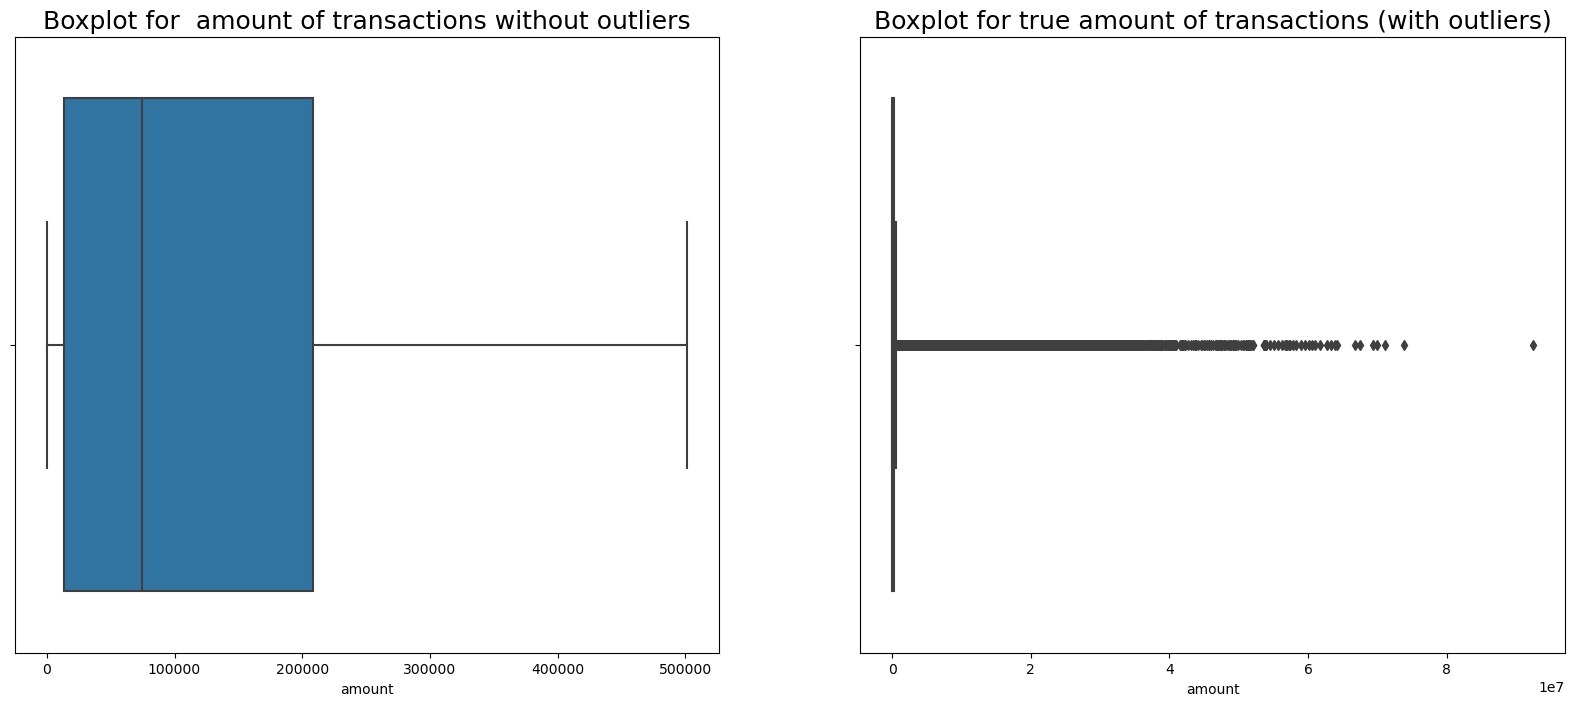

In [214]:
plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Boxplot for  amount of transactions without outliers", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = False)

two = plt.subplot(1, 2, 2)
two.set_title("Boxplot for true amount of transactions (with outliers)", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = True)

plt.show()

Observing on the right the "true" **amount** is heavy the presence of outliers: the box is flat. Visually the imagine on the left tells us expicitely the distibution it's strongly asymmetric (mean > median). 

>- The most (75%) of transactions are under 208'722$;
>- on average we have an amount of 179'862$;
>- 50% of transactions is under 74'872$.

In the next cell the statistics that confirm the boxplot results. 
We know that is these cases the mean is NOT a good summary for the distribution that lieas behind our data. The outliers are pretty isolated and could cause a large distrosion of information if not well managed!

In [215]:
print(data.amount.describe().to_markdown())
print("Median : " + str(median(data.amount)))

|       |           amount |
|:------|-----------------:|
| count |      6.36262e+06 |
| mean  | 179862           |
| std   | 603858           |
| min   |      0           |
| 25%   |  13389.6         |
| 50%   |  74871.9         |
| 75%   | 208721           |
| max   |      9.24455e+07 |
Median : 74871.94


Later we will justify all this attention we pay to the "amount" feature with the analysis of multi-collinearity and feature importance ranking.

We now proceed with the analysis of the impact that outliers have on the distribution of fraudulent cases only and note that in general a very small fraction have high amounts. In contrast, the most suspicious transactions will be those at lower amounts of money moved.

In [7]:
# dataset divided by isFraud
F=data[data.isFraud==1]
NF=data[data.isFraud==0]

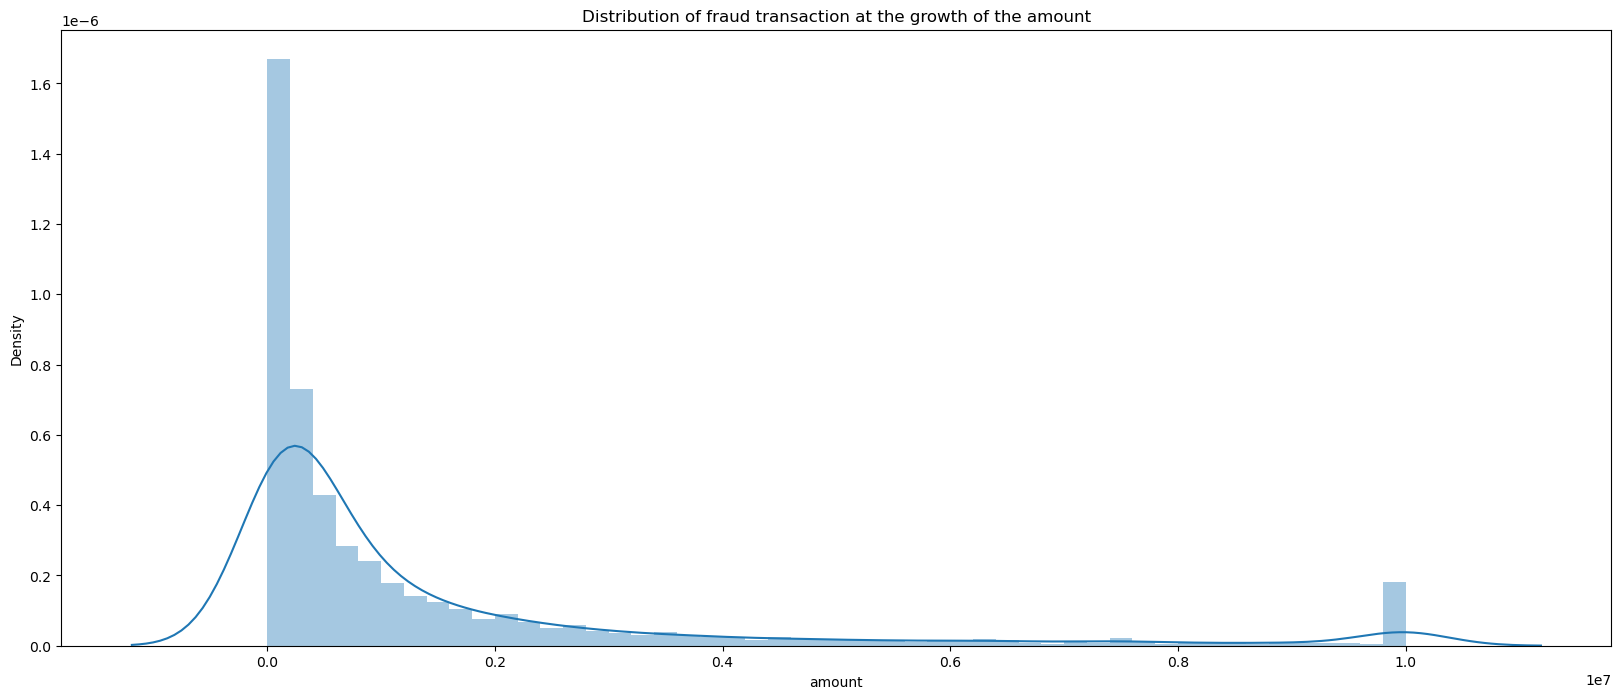

In [ ]:
plt.figure(figsize=(20, 8))
sns.distplot(F['amount'])
plt.title("Distribution of fraud transaction at the growth of the amount", fontdict=None, loc='center')
plt.show()

### Analysis of types of transactions

Let's take a look at the number of fraud and legit transaction. Then more strictly which types are the "dangerous".

In [5]:
print("In absolute : \n" + str(data.isFraud.value_counts()))
print("-------------------------------")
print("In proportion : \n" + str(data.isFraud.value_counts(1)))

In absolute : 
0    6354407
1       8213
Name: isFraud, dtype: int64
-------------------------------
In proportion : 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [8]:
print("Number of not fraud transaction per type : \n " + str(NF.type.value_counts()) + "\n")
print("-------------------------------------------")
print("Number of fraud transaction per type : \n " + str(F.type.value_counts()))

Number of not fraud transaction per type : 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

-------------------------------------------
Number of fraud transaction per type : 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


We report the plot of what we have found above.

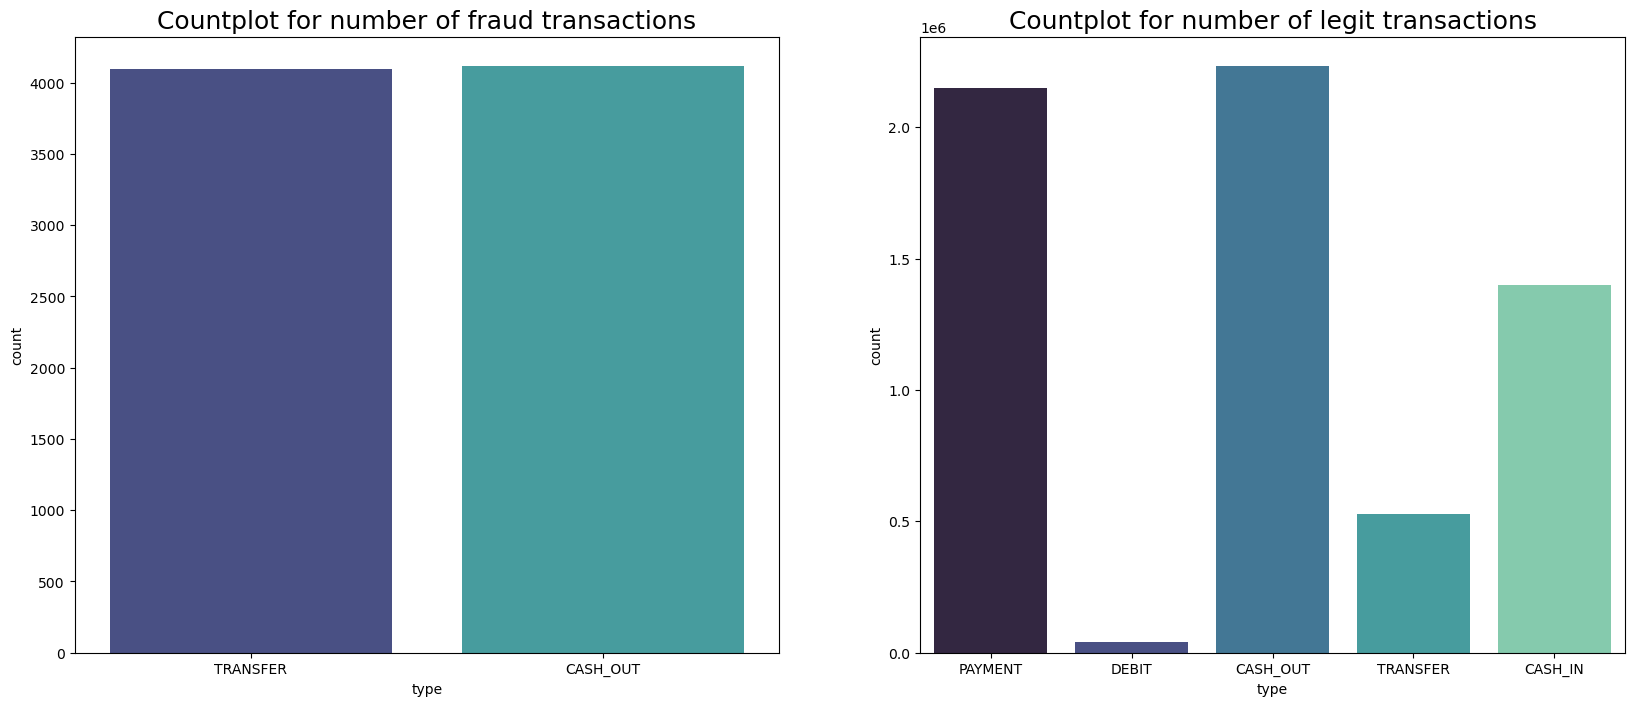

In [217]:
plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Countplot for number of fraud transactions", 
             {"fontsize":18})
sns.countplot(F.type, palette='mako')

two = plt.subplot(1, 2, 2)
two.set_title("Countplot for number of legit transactions", 
             {"fontsize":18})
sns.countplot(NF.type, palette='mako')

plt.show()

The number of fraud movements is 8213, the 0.1% of the total. They are divided between the types "CASH_OUT" and "TRANSER" and respect to the amount mostly present with small ones.

Given that there are no fraudulent transactions outside the 'CASH OUT' and 'TRANSFER' types let's see how a possible change on the number of features might impact eliminating dataframe columns associated with transaction types outside those mentioned above.
We will do a multi-collinearity analysis of the data set before and after the feature changes. But at this stage of analysis we explore how this might change the distribution of the faeture most important to our target.

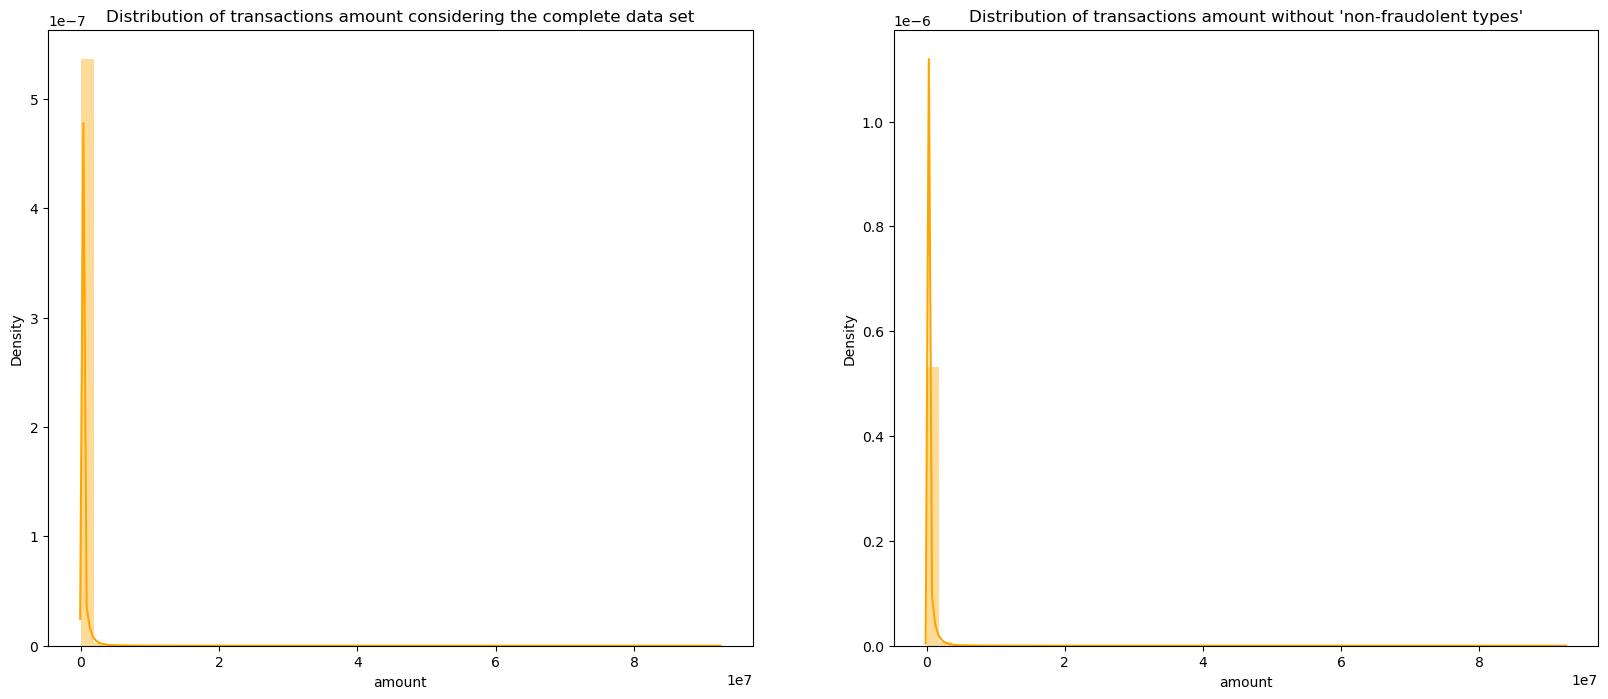

In [9]:
fraud =  data.loc[(data.type == 'CASH_OUT') | (data.type =='TRANSFER')]

plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Distribution of transactions amount considering the complete data set", 
             {"fontsize":12})
sns.distplot(data['amount'], color='orange')

two = plt.subplot(1, 2, 2)
two.set_title("Distribution of transactions amount without 'non-fraudolent types'", 
             {"fontsize":12})
sns.distplot(fraud['amount'], color='orange')
plt.show()

As we can see from the plots (and as we will confirm analytically in feature engineering), removing the columns of types without fraudulent transactions does not change the distribution of the most impactful feature. In gnereal, the removed faetures will be uninformative for finding the solution to our classification.

### Profiling customers

There are two type of Customers according to the CustomerID 'signature' ('nameOrig' and 'nameDest' columns):

1. One starts with 'M' and represents 'Merchant' acoounts -> on them we do not have their account baòcance change after the transaction;ù

2. The other starts with 'C' that stands for 'Customer' account (we have more information on them).

In [11]:
len(fraud.loc[fraud.nameOrig.apply(lambda row: row.startswith('C'))]) == len(fraud)

True

In [12]:
len(fraud.loc[fraud.nameDest.apply(lambda row: row.startswith('C'))]) == len(fraud)

True

#### WARNING! 

All fraudolent transactions occur betweeen acoounts of type 'C' 

In [10]:
print("Total number different registered transaction senders:", data['nameOrig'].nunique())

Total number different registered transaction senders: 6353307


In [11]:
print("Total number different registered transaction receivers:", data['nameDest'].nunique())

Total number different registered transaction receivers: 2722362


### Does the flagging from the bank work???

Only a minuscule proportion of fraudulent transactions are preemptively reported correctly in the data set. So we decide to exclude this feature for our classification.

In [222]:
data.isFlaggedFraud.value_counts() #we will drop this column because irrilevant

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

# Feature engineering

### Handling categorical variables

One of the key points of feature engineering is to convert all variables to numerical. We distinguish two cases in particular:

>- transaction types constitute a categorical feature variable (five unique values) and can be converted to Boolean variables with relative column explosion into five columns by one-hot encoding;

>- all columns related to Customer IDs are strings -> we simply hash the corresponding cells into numeric values.

##### One-hot encoding

In [53]:
types = pd.get_dummies(data.type, prefix='type', drop_first=True)
#By dropping one of the one-hot encoded columns from each categorical feature, we ensure there are no "reference" columns and the remaining columns become linearly independent.
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


Note that there are actually only four types: thus we will not have linear dependence between the derived columns.

##### Hashing strings

In [54]:
# we simply use the built-in hash function in python

data['nameOrig'] = data.nameOrig.apply(lambda row: hash(row))
data['nameDest'] = data.nameDest.apply(lambda row: hash(row))

In [55]:
data[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,-1031907157066206408,2318882386296206736
1,-8481276002277591266,3924715420015345732
2,-5298265140449908946,5957117159562947628
3,-5617833629400080748,6320636984604363552
4,-3795105120072025340,1908302968080402418
...,...,...
6362615,-5595391562349993486,2237292908357735229
6362616,8136871846831068364,2753666501186346757
6362617,5380605601817742045,1007087262519635374
6362618,-2310665580864952401,-8802678897215451152


In [56]:
#putting all together
data = pd.concat([data, types], axis=1)
data = data.drop('type', axis=1)
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,-1031907157066206408,170136.0,160296.36,2318882386296206736,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,-8481276002277591266,21249.0,19384.72,3924715420015345732,0.0,0.0,0,0,0,0,1,0
2,1,181.00,-5298265140449908946,181.0,0.00,5957117159562947628,0.0,0.0,1,0,0,0,0,1
3,1,181.00,-5617833629400080748,181.0,0.00,6320636984604363552,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,-3795105120072025340,41554.0,29885.86,1908302968080402418,0.0,0.0,0,0,0,0,1,0


Let's take an important step to get the basis to our model: how do the variables behave respect to each other?

### Dimensionality reduction and multi-collinearity

In order to reduce computational complexity, a reduction in the dimesion (in terms of number of features) of our data set is planned.

After checking the type and nature of features, we continue with the removal of features with low impact on the search for the solution to our problem. We then resume the considerations explicated in EDA and delve analytically :

>- we analyze the pairwise correlation that exists between the reference variables;

>- we rely on the study of multicollinearity for the identification of "problem" features.

#### Correlation

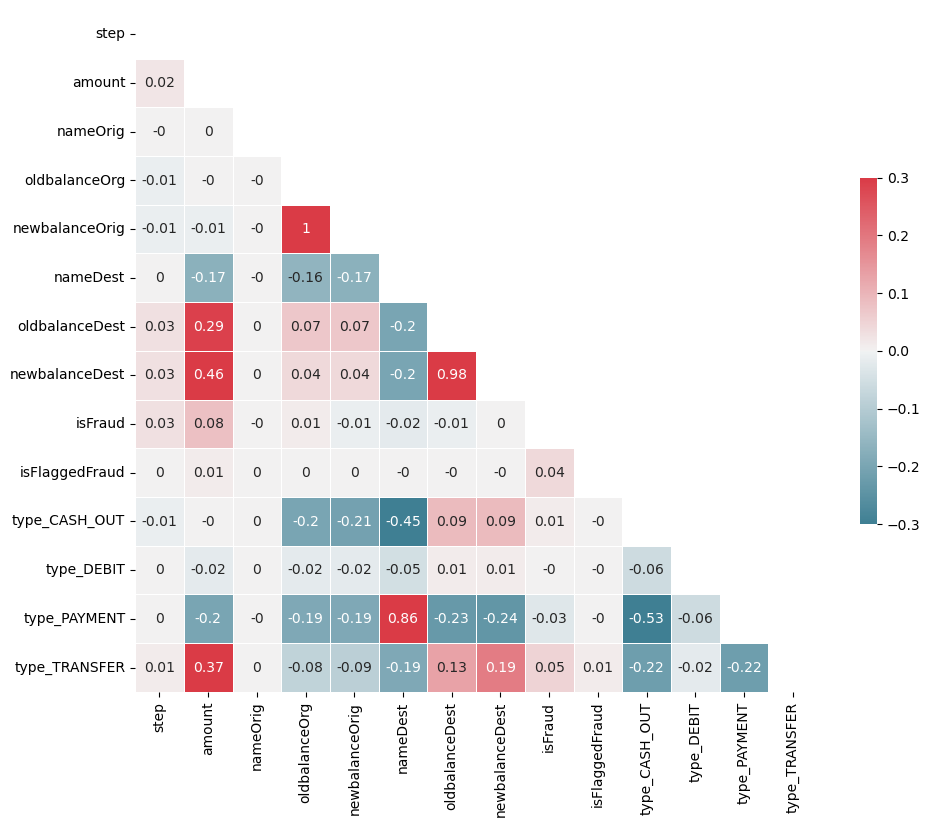

In [229]:
f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(data.corr(), cmap='mako', linewidth=0.2, annot=True)
#plt.show()

corr=round(data.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)
plt.show()

The existence of collinearity inflates the variances of the parameter estimates, and consequently incorrect inferences about relationships between explanatory and response variables. Examining the correlation matrix may be helpful to detect multicollinearity, but not sufficient. Much better diagnostics are produced by linear regression with **VIF**.

#### Multi-Collinearity analysis

In statistics, **multicollinearity** (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a degree of accuracy. The coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

"No multicollinearity" refers to the absence of perfect multicollinearity, which is an exact (non-stochastic) linear relation among the predictors. In such a case, the design matrix $X$ has less than full rank, and therefore the moment matrix $X^{T}X$ cannot be inverted. Under these circumstances, for a general linear model $y=X\beta +\epsilon$ , the ordinary least squares estimator  $\hat{\beta }_{OLS}=(X^{T}X)^{-1}X^{T}$ does not exist.

A formal detection-tolerance for the variance inflation factor (VIF) for multicollinearity is given by:

**tolerance** $= 1-R_{j}^{2}$      ,              **VIF** $ =\frac{1}{tolerance}$

where $R_{j}^{2}$ is the "coefficient of determination" of a regression (proportion of the variation in the dependent variable that is predictable from the independent variables)  of explanator j on all the other explanators. A tolerance of less than 0.20 or 0.10 and/or a VIF of 5 or 10 and above indicates a multicollinearity problem.

In [39]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "nameOrig":data.nameOrig,
                                "nameDest":data.nameDest,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFlaggedFraud":data.isFlaggedFraud,
                               "type_CASH_OUT":data.type_CASH_OUT,
                               "type_DEBIT":data.type_DEBIT,
                               "type_PAYMENT":data.type_PAYMENT,
                               "type_TRANSFER":data.type_TRANSFER})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
vif_data_sort=vif_data.sort_values(by=['VIF'], ascending=False)
display(vif_data_sort)

,feature,VIF
5,newbalanceOrig,428.693436
4,oldbalanceOrg,428.309108
7,newbalanceDest,73.946539
6,oldbalanceDest,63.765295
1,amount,3.547283
12,type_TRANSFER,1.123935
8,isFlaggedFraud,1.000562
3,nameDest,1.000004
2,nameOrig,1.000001
10,type_DEBIT,0.994821


In [40]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

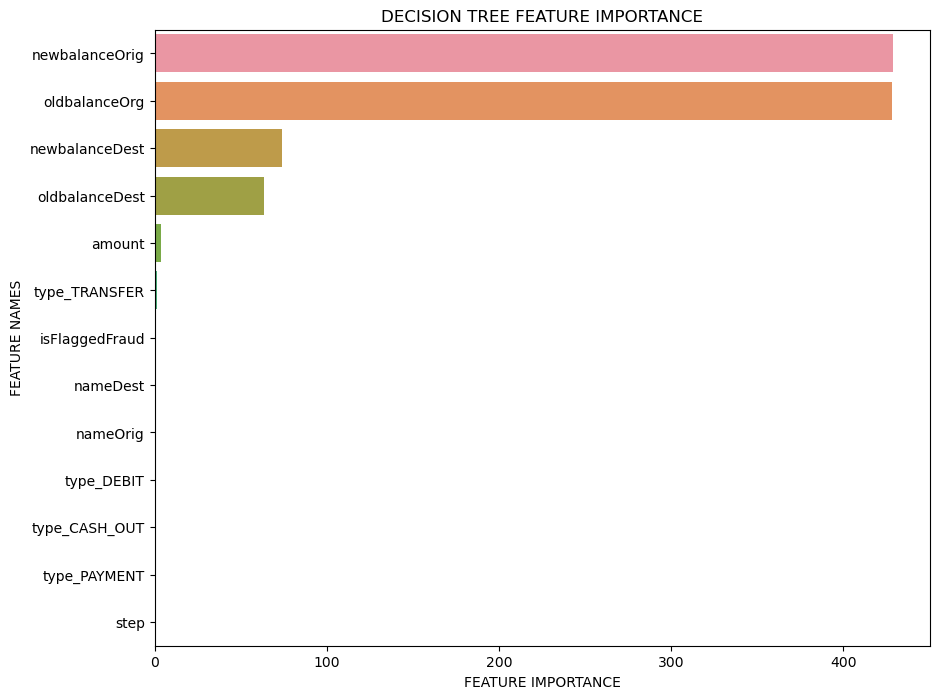

In [41]:
plot_feature_importance(vif_data_sort['VIF'],vif_data_sort['feature'],'DECISION TREE ')

Most research papers consider a VIF (Variance Inflation Factor) > 10 as an indicator of multicollinearity. 

https://quantifyinghealth.com/vif-threshold/

Dangerous variables:

1. oldbalanceorg and newbalanceorig
2. oldbalanceDest and newbalanceDest

Prevention:

For moderate to large sample sizes, the approach to drop one of the correlated variables was established entirely satisfactory to reduce multicollinearity. 

https://www.tandfonline.com/doi/abs/10.1080/09720502.2010.10700699?journalCode=tjim20#:~:text=Multicollinearity%20is%20a%20statistical%20phenomenon%20in%20which%20two%20or%20more,relationships%20among%20the%20explanatory%20variables.

##### Managing VIF indexes

In the case of 'oldbalanceOrg' and 'newbalanceOrig' we decide to reduce the information reported by the two columns into one column. In addition, the net change value of the transaction is not particularly interesting: note that a large proportion of the transactions do NOT present source account balance variation. We therefore prefer one-hot ecoding in this case. 

In [ ]:
print("Balances changed: " + str(bal_change.count(1))+ "\n" + "Balances not changed : " + str(bal_change.count(0)))

Balances changed: 1399253
Balances not changed : 4963367


In [57]:
old_balance=data["oldbalanceOrg"]  # initial balance before the transaction
new_balance=data["newbalanceOrig"] # new balance after the transaction
bal_change=[] #if balace decrease: 1 else 0
for i in range(len(old_balance)):
    diff=new_balance[i]-old_balance[i]
    if diff>0:
        bal_change.append(1)
    else:
        bal_change.append(0)

For 'oldbalanceDest' and 'oldbalanceDest' we chose instead to replace these features with a column containing the recipient's account balance change.

In [58]:
dest_old=data["oldbalanceDest"] # initial balance recipient before the transaction
dest_new=data["newbalanceDest"] # new balance recipient after the transaction
dest_bal_change=[]
dest_bal=[]
for i in range(len(dest_old)):
    diff=dest_new[i]-dest_old[i]
    dest_bal.append(abs(diff))

In [59]:
data["source_bal_change"]=bal_change
data["destinationBal"]=dest_bal

##### Dropping columns

In [60]:
data.drop(["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFlaggedFraud"],axis=1,inplace=True)

In [61]:
data.head()

,step,amount,nameOrig,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,-1031907157066206408,2318882386296206736,0,0,0,1,0,0,0.0
1,1,1864.28,-8481276002277591266,3924715420015345732,0,0,0,1,0,0,0.0
2,1,181.00,-5298265140449908946,5957117159562947628,1,0,0,0,1,0,0.0
3,1,181.00,-5617833629400080748,6320636984604363552,1,1,0,0,0,0,21182.0
4,1,11668.14,-3795105120072025340,1908302968080402418,0,0,0,1,0,0,0.0


Later we will verify that even removing the 'type_DEBIT' and 'type_PAYMENT' columns does not invalidate the models used for classification and the various sampling techniques reported. In fact, these columns contain only zeros for the rows corresponding to fraudulent transactions.

#### Double checking multi-collinearity after our edits to the data frame

Effectively we have now obtained the desired results: each feature has a VIF index < 10 !!

In [47]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "nameOrig":data.nameOrig,
                                "nameDest":data.nameDest,
                               "source_bal_change":data.source_bal_change,
                               "destinationBal":data.destinationBal,
                               "type_CASH_OUT":data.type_CASH_OUT,
                               "type_DEBIT":data.type_DEBIT,
                               "type_PAYMENT":data.type_PAYMENT,
                               "type_TRANSFER":data.type_TRANSFER})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
vif_data_sort=vif_data.sort_values(by=['VIF'], ascending=False)
display(vif_data_sort)

,feature,VIF
5,destinationBal,4.035244
1,amount,3.906006
9,type_TRANSFER,1.112331
2,nameOrig,1.000000
3,nameDest,0.999997
7,type_DEBIT,0.993511
4,source_bal_change,0.794630
6,type_CASH_OUT,0.666700
8,type_PAYMENT,0.662263
0,step,0.273988


In [48]:
# saving the modified data set in a pickle file
data.to_pickle('transaction.pkl')

In [6]:
data=pd.read_pickle('transaction.pkl')

In [6]:
data.head(10)

,step,amount,nameOrig,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,-1031907157066206408,2318882386296206736,0,0,0,1,0,0,0.00
1,1,1864.28,-8481276002277591266,3924715420015345732,0,0,0,1,0,0,0.00
2,1,181.00,-5298265140449908946,5957117159562947628,1,0,0,0,1,0,0.00
3,1,181.00,-5617833629400080748,6320636984604363552,1,1,0,0,0,0,21182.00
4,1,11668.14,-3795105120072025340,1908302968080402418,0,0,0,1,0,0,0.00
5,1,7817.71,-771538048454768957,-2316597571880969274,0,0,0,1,0,0,0.00
6,1,7107.77,-3579698928106105942,-4997561535341337870,0,0,0,1,0,0,0.00
7,1,7861.64,3442010222989013794,605010144636576093,0,0,0,1,0,0,0.00
8,1,4024.36,8697415547998651938,3745013556175883540,0,0,0,1,0,0,0.00
9,1,5337.77,7738632942853147270,7869233084525012234,0,0,1,0,0,0,1549.21


# Model selection

## Logistic regression

Splitting the data set in inputs and targets and than in train and test set.

In [31]:
# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

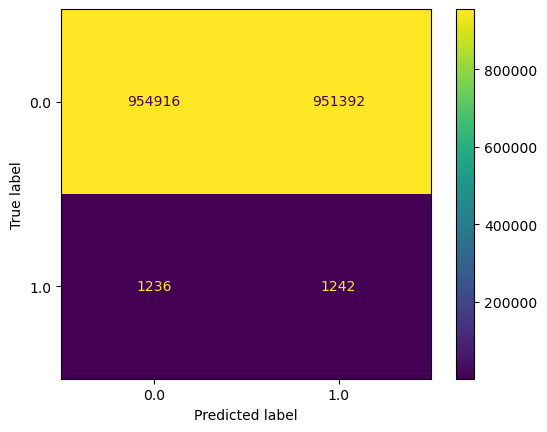

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
cf=confusion_matrix(y_test,predictions,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=lr.classes_)
disp.plot()
plt.show()

In [74]:
print(classification_report(y_test,predictions,target_names=['NotFraudolent','Fraudolent']))

               precision    recall  f1-score   support

NotFraudolent       1.00      0.50      0.67   1906308
   Fraudolent       0.00      0.50      0.00      2478

     accuracy                           0.50   1908786
    macro avg       0.50      0.50      0.33   1908786
 weighted avg       1.00      0.50      0.67   1908786



From the analysis of the output metrics of the logistic regression, we note that the quality of the model is low: in fact, despite good recall, we get practically zero accuracy and precision.

We can improve the quality in general by exploiting particular sampling techniques (as we will see later). However, we prefer to abandon a logistic classification regardless of further manipulation of the sample. 

In fact, as we can see in the <a href="https://blog.bigml.com/2016/09/28/logistic-regression-versus-decision-trees/#:~:text=Decision%20Trees%20bisect%20the%20space,generalize%20to%20planes%20and%20hyperplanes.">linked article</a>, Logistic Regression and trees differ in the way that they generate decision boundaries i.e. the lines that are drawn to separate different classes. Decision Trees bisect the space into smaller and smaller regions, whereas Logistic Regression fits a single line to divide the space exactly into two. Of course for higher-dimensional data, these lines would generalize to planes and hyperplanes. A single linear boundary can sometimes be limiting for Logistic Regression. In this example where the two classes are separated by a decidedly non-linear boundary, we see that trees can better capture the division, leading to superior classification performance. However, when classes are not well-separated, trees are susceptible to overfitting the training data, so that Logistic Regression’s simple linear boundary generalizes better.


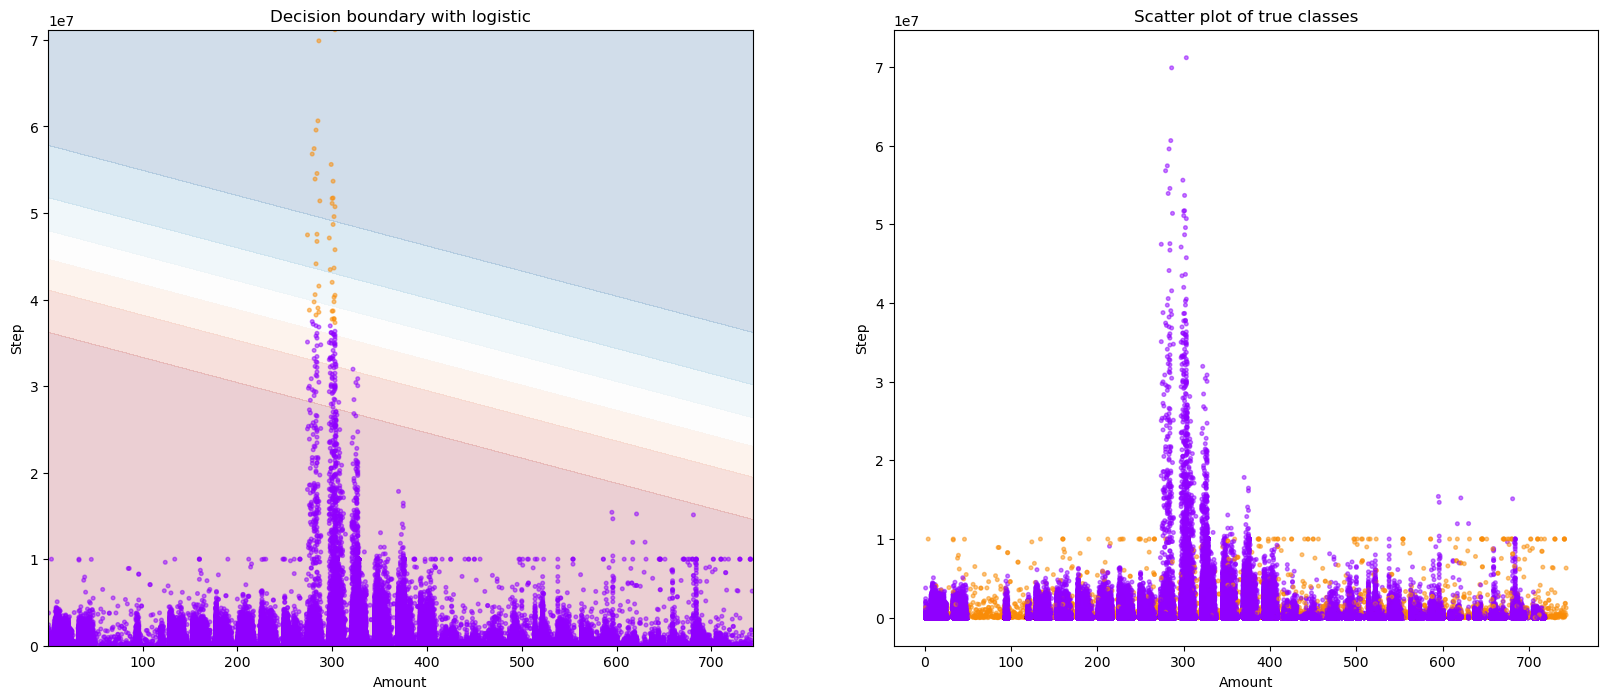

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Split the data into input features and target variable
X_train = X_train[['amount', 'step']]
X_test = X_test[['amount', 'step']]

# Create a pipeline with a logistic regression model and standard scaler
model = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

# Fit the model to the data
model.fit(X_train, y_train)

# Generate a mesh of input feature values
x1_min, x1_max = X_test['amount'].min() - 0.5, X_test['amount'].max() + 0.5
x2_min, x2_max = X_test['step'].min() - 0.5, X_test['step'].max() + 0.5
x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))

# Predict the class probabilities for the mesh of input feature values
X_new = np.c_[x1.ravel(), x2.ravel()]
y_proba = model.predict_proba(X_new)
y_pred =pd.Series(model.predict(X_test))
colors = ['#8F00FF','#f98c07']
y_col = y_pred.map({i: colors[i] for i in range(0,2)})
y_col2 = pd.Series(y_test).map({i: colors[i] for i in range(0,2)})

plt.figure(figsize=(20, 8))
one = plt.subplot(1, 2, 1)
one.contourf(x2, x1, y_proba[:, 1].reshape(x1.shape), cmap='RdBu', alpha=0.2)
one.scatter(X_test['step'], X_test['amount'], s= 7, c=y_col, alpha=0.5)
one.set_title('Decision boundary with logistic')

two = plt.subplot(1, 2, 2)
two.scatter(X_test['step'], X_test['amount'],c =y_col2, s= 7, alpha=0.5)
two.set_title('Decision boundary with logistic')
two.set_title("Scatter plot of true classes", 
             {"fontsize":12})

one.set(xlabel="Amount", ylabel="Step")
two.set(xlabel="Amount", ylabel="Step")
plt.show()

## Decision tree without resampling

In [38]:
# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

In [46]:
dt=DecisionTreeClassifier(max_depth=4)
dt=dt.fit(X_train,y_train)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [47]:
predictions=dt.predict(X_test)

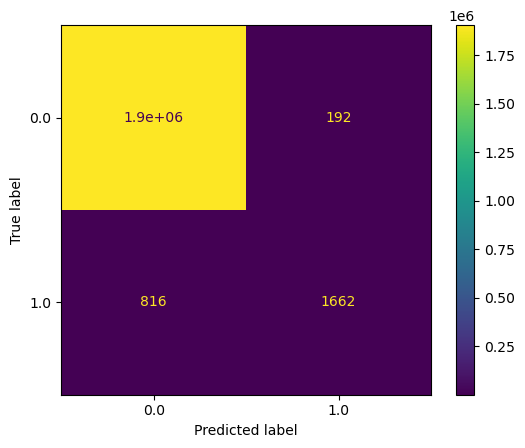

In [48]:
cf=confusion_matrix(y_test,predictions,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In [49]:
print(classification_report(y_test,predictions,target_names=['NotFraudolent','Fraudolent']))

               precision    recall  f1-score   support

NotFraudolent       1.00      1.00      1.00   1906308
   Fraudolent       0.90      0.67      0.77      2478

     accuracy                           1.00   1908786
    macro avg       0.95      0.84      0.88   1908786
 weighted avg       1.00      1.00      1.00   1908786



## Decision tree with different sampling tachniques

The following resampling techniques will be useful in making the data set balanced according to the number of fraudulent and non-fraudulent transactions.

### Undersampling

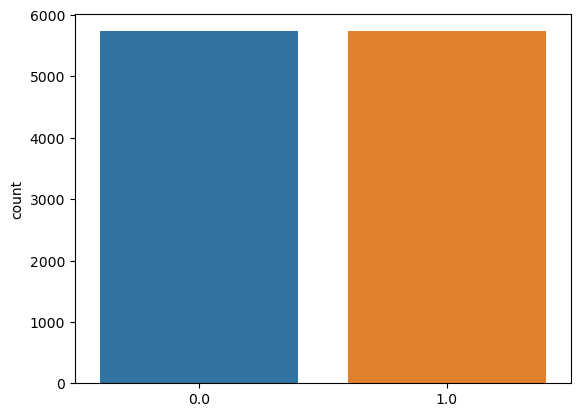

In [329]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(X_train, y_train)

sns.countplot(y_train)
plt.show()

Model Score: 0.9107280753316506
ROC_AUC_Score 0.9035170876375916
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95   1906308
         1.0       0.01      0.90      0.03      2478

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786



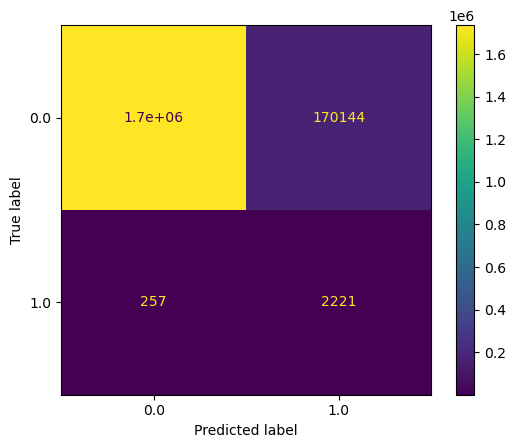

In [330]:

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
pred = dt.predict(X_test)
print('Model Score:', dt.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In [332]:
# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
      

### Oversampling

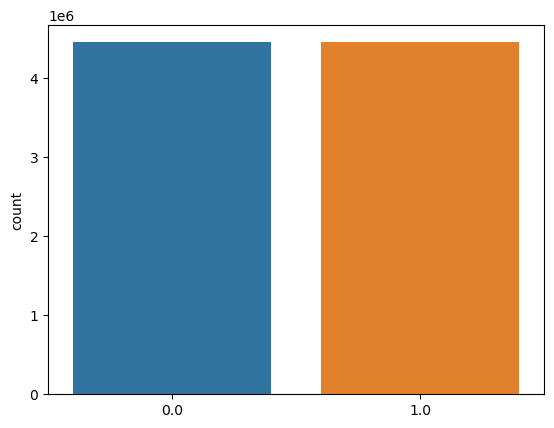

In [34]:
from imblearn.over_sampling import RandomOverSampler

rus = RandomOverSampler()
x_train, y_train = rus.fit_resample(X_train, y_train)

sns.countplot(y_train)
plt.show()


Model Score: 0.9993660892315849
ROC_AUC_Score 0.8592278357403058
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1906308
         1.0       0.78      0.72      0.75      2478

    accuracy                           1.00   1908786
   macro avg       0.89      0.86      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786



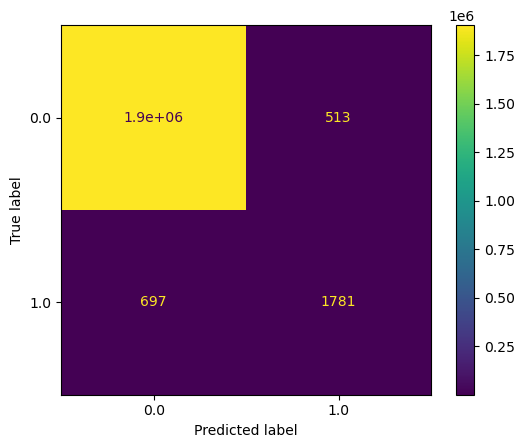

In [40]:
model_ov = DecisionTreeClassifier()
model_ov.fit(x_train, y_train)
pred = model_ov.predict(X_test)
print('Model Score:', model_ov.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=model_ov.classes_)
disp.plot()
plt.show()

### SMOTE

Model Score: 0.9812032359834995
ROC_AUC_Score 0.9132082791364352
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   1906308
         1.0       0.06      0.85      0.10      2478

    accuracy                           0.98   1908786
   macro avg       0.53      0.91      0.55   1908786
weighted avg       1.00      0.98      0.99   1908786



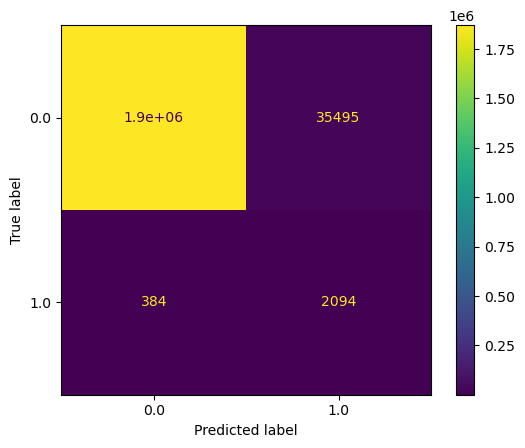

In [336]:
from imblearn.over_sampling import SMOTE


X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)


sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(X_train, y_train)

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(X_test)
print('Model Score:', model.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In the last case, using the Smote methodology we get better results in general than the other simple oversampling and undersampling techniques. It actually makes the quality of the precision metric much worse in order to get better recall than the sample from the original data set. The reason we are satisfied with the last confusion matrix is that in fraud detection we largely prefer to minimize the error in terms of false negatives, partly ignoring the amount of false positives obtained (less critical amount. The context reported here is one of the classic cases of the preference of alarmism over failure to identify positive cases.

#### Feature importance after resampling

So ultimately we can say that the oversampling technique leads to better results. However, let us do a little verification: indeed, with such a capampling technique we could change the hierarchical relationships among the input features. Any changes in feature importance could cost us a return of multi-collinearity problems. 

Indeed, we report below a measure of feature importance considering the application of a tree model with oversampling before and after and note that all seems to have remained more or less stable.

In [42]:
feature_names=X.columns
feature_names

Index(['step', 'amount', 'nameOrig', 'nameDest', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'source_bal_change', 'destinationBal'],
      dtype='object')

In [50]:
#feature impportance before SMOTE
feature_importance_dt=pd.DataFrame(dt.feature_importances_,index=feature_names,columns=['Importance_DT'])
#feature_importance_dt

#feature importance on Oversampled dataframe 
feature_importance_ov=pd.DataFrame(model_ov.feature_importances_,index=feature_names,columns=['Importance_DT'])
#feature_importance_ov

feature_importance_dt.compare(feature_importance_ov).rename(columns={'self':'DTree','other':'DT_Oversamp'})


Importance_DT            
                          DTree DT_Oversamp
step                   0.059183    0.167398
amount                 0.066001    0.263659
nameOrig               0.000000    0.046028
nameDest               0.000000    0.046457
type_CASH_OUT          0.000000    0.168239
type_TRANSFER          0.148981    0.192180
source_bal_change      0.000000    0.013036
destinationBal         0.725835    0.103003

<AxesSubplot:>

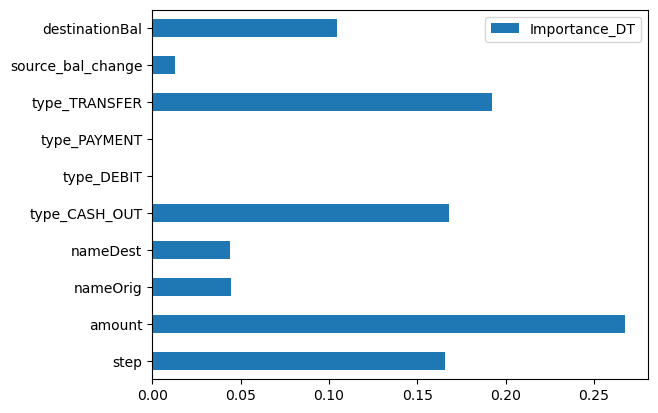

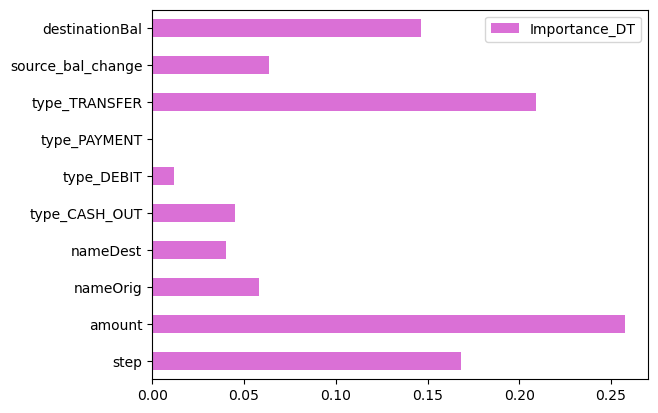

In [359]:
features=list(feature_importance_dt[feature_importance[0]>0].index)
features=list(feature_importance_ov[feature_importance[0]>0].index)
feature_importance_dt.plot.barh()
feature_importance_ov.plot.barh(color='orchid')

#### Further dimensionality reduction

Having identified the best sampling technique, we can go back to the thesis reported in analyzing and cleaning the data set: types that do not involve fraudulent functions can be eliminated by implying no change in the hierarchical relationship between the input variables.

In [51]:
del data['type_PAYMENT'] 
del data['type_DEBIT']

## Visualizing decision tree with oversampling

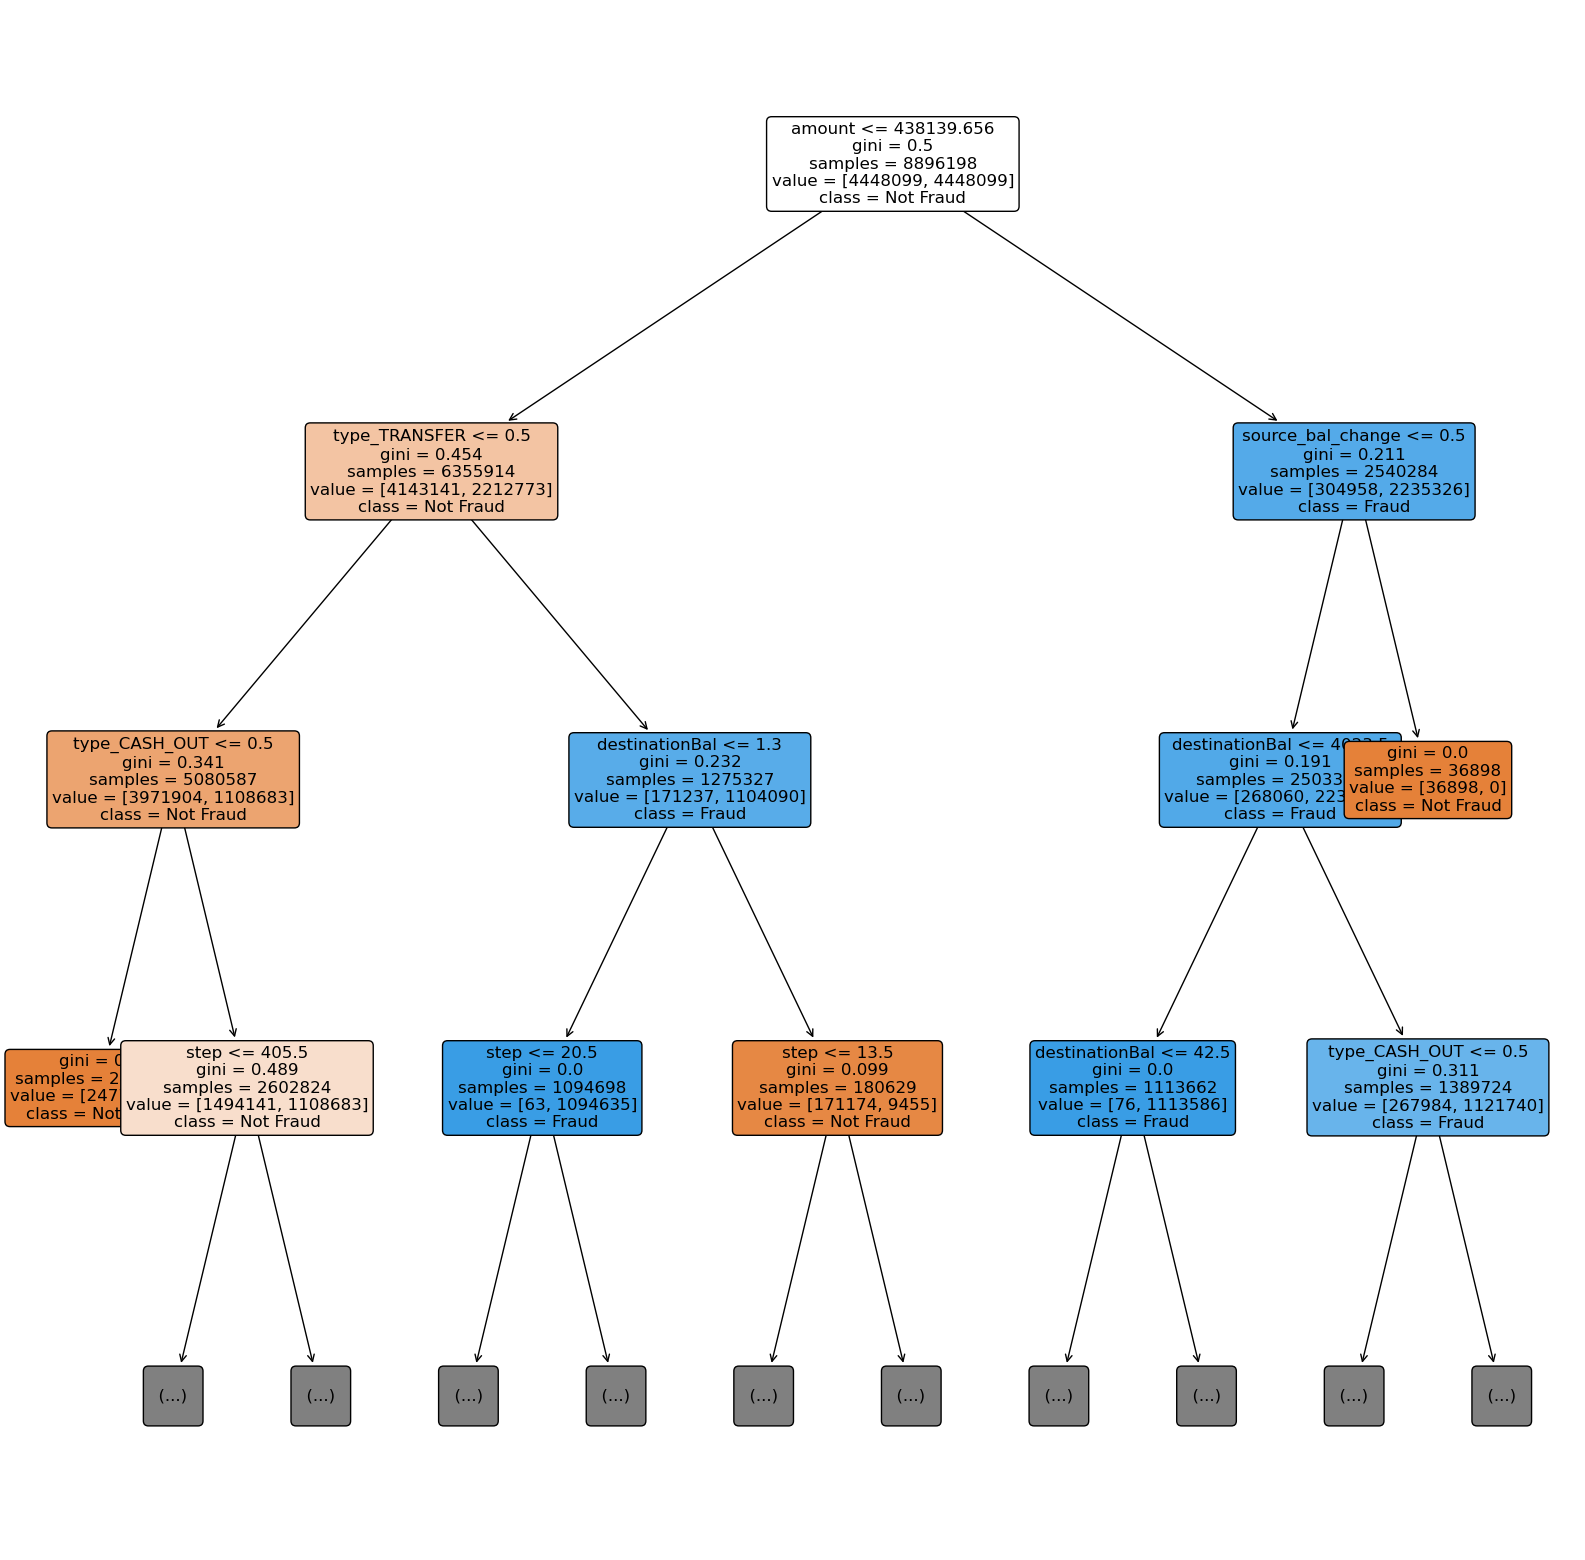

In [56]:
from sklearn import tree
from  matplotlib import pyplot as plt

fig=plt.figure(figsize=(20,20))
_=tree.plot_tree(model_ov,max_depth=3,
                feature_names=feature_names,
                class_names={0:'Not Fraud',1:'Fraud'},
                filled=True,rounded=True,
                fontsize=12)

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [39]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)
# define the model
model = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2)
# define the model evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [68]:
from imblearn.over_sampling import RandomOverSampler

# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,9) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

rus = RandomOverSampler()
x_train, y_train = rus.fit_resample(X_train, y_train)


Model Score: 0.8857535627356865
ROC_AUC_Score 0.8592278357403058
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1906308
         1.0       0.78      0.72      0.75      2478

    accuracy                           1.00   1908786
   macro avg       0.89      0.86      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786



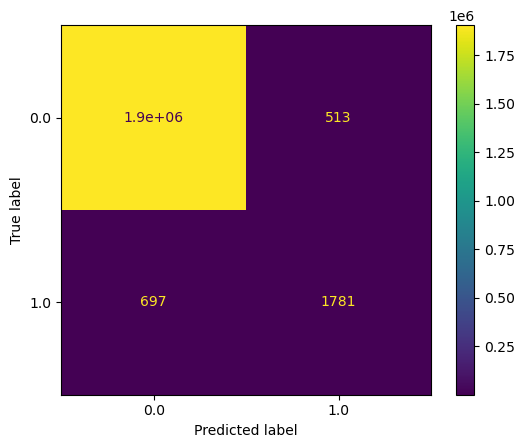

In [70]:
boost_class = XGBRFClassifier()
# fit the model on the whole dataset
boost_class.fit(x_train, y_train)

yhat = boost_class.predict(X_test)
print('Model Score:', boost_class.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=boost_class.classes_)
disp.plot()
plt.show()